# Model validation

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.999' # NOTE: jax preallocates GPU (default 75%)
# from jax.config import config; config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util, pmap
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("Model Validation")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


## Render model

In [2]:
rsd = True
smooth = False

In [3]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_cosmo, get_noise_fn
from montecosmo.models import print_config, condition_on_config_mean, default_config as config
# Build and render model
config.update(a_lpt=0.1, mesh_size=256*np.ones(3, dtype=int), box_size=640*np.ones(3), 
              trace_reparam=True, trace_meshes=True) # 256 requires 20Gio, 1000
config['prior_config']['b1'][1] = 0.5
config['lik_config']['obs_std'] = 1/64
model = partial(pmrsd_model, **config)
print_config(model)
# numpyro.render_model(model=model, render_params=True) # filename="model_DAG.png"

# CONFIG
{'mesh_size': array([256, 256, 256]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.1, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_meshes': True, 'prior_config': {'Omega_c': ['{\\Omega}_c', 0.25, 0.1], 'sigma8': ['{\\sigma}_8', 0.831, 0.14], 'b1': ['{b}_1', 0.5, 0.5], 'b2': ['{b}_2', 0, 0.5], 'bs2': ['{b}_{s^2}', 0, 0.5], 'bn2': ['{b}_{\\nabla^2}', 0, 0.5]}, 'lik_config': {'obs_std': 0.015625}}

# INFOS
cell_size:        [2.5, 2.5, 2.5] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        1.25664 h/Mpc
mean_gxy_density: 0.016 gxy/cell



## Simulate fiducial

In [4]:
# Get fiducial parameters
# fiduc_params = jit(get_simulator(condition_on_config_mean(partial(model, lik_config={'obs_std':0}))))(rng_seed=0)
fiduc_params = jit(get_simulator(condition_on_config_mean(model)))(rng_seed=0)

# Get and vectorize relevant functionals
multipoles = [0,2,4]
pk_fn = get_pk_fn(multipoles=multipoles, **config)
from jax_cosmo import Planck15
fiduc_cosmo = Planck15(**get_cosmo(**config, **fiduc_params))
print(f"Fiducial {fiduc_cosmo}")

/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


In [4]:
# # pickle_dump(fiduc_params['pm_part'][...,:3], 'pm_pos_22.p')

# from jaxpm.painting import cic_paint
# zeros_mesh = jnp.zeros(config['mesh_size'])
# pm_pos = pickle_load('pm_pos_22.p')
# pm_mesh = jnp.zeros((22, *config['mesh_size']))
# for i in range(5):
#     pm_mesh = pm_mesh.at[4*i:4*(i+1)].set(vmap(cic_paint, in_axes=(None,0))(zeros_mesh, pm_pos[4*i:4*(i+1),:,:3]))
# pm_mesh = pm_mesh.at[-2:].set(vmap(cic_paint, in_axes=(None,0))(zeros_mesh, pm_pos[-2:,:,:3]))
# pickle_dump(pm_mesh, 'pm_mesh_22.p')

In [12]:
print(fiduc_params.keys())
from jaxpm.painting import cic_paint
zeros_mesh = jnp.zeros(config['mesh_size'])
rsd_mesh = cic_paint(zeros_mesh, fiduc_params['rsd_part'][:,:3])
pm_mesh = pickle_load('pm_mesh_12.p')

dict_keys(['Omega_c', 'Omega_c_', 'b1', 'b1_', 'b2', 'b2_', 'bias_mesh', 'bias_prersd_mesh', 'bn2', 'bn2_', 'bs2', 'bs2_', 'init_mesh', 'init_mesh_', 'obs_mesh', 'pm_part', 'rsd_part', 'sigma8', 'sigma8_'])


In [6]:
# mlflow.end_run()
# mlflow.start_run(run_name="Valid Pk 256, -")
# # mlflow.start_run(run_id="")
# mlflow.log_params(config)

## Power spectra

In [9]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# # Get meshes from model trace particles. Must compensate for CIC painting convolution
# zeros_mesh = jnp.zeros(config['mesh_size'])
# pm_mesh = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_params['pm_part'][...,:3])
# rsd_mesh = cic_paint(zeros_mesh, fiduc_params['rsd_part'][:,:3])

# # Compute power spectra
# pk_init = pk_fn(fiduc_params['init_mesh'])
# pk_pm = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh))
# pk_rsd = pk_fn(compensate_cic(rsd_mesh))
# pk_bias = pk_fn(compensate_cic(fiduc_params['bias_mesh']))
# pk_lin_init = np.array([pk_init[0], linear_pk_interp(fiduc_cosmo)(pk_init[0])])
# pk_lin_obs = np.array([pk_init[0], linear_pk_interp(fiduc_cosmo, a=config['a_obs'])(pk_init[0])])

# from montecosmo.metrics import kaiser_formula
# from montecosmo.bricks import apply_kaiser_bias

# fiduc_kaiser_bias = condition(apply_kaiser_bias, {'b': 1+fiduc_params['b1']})
# kaiser_mesh = fiduc_kaiser_bias(fiduc_cosmo, config['a_obs'], fiduc_params['init_mesh'])
# pk_kaiser_bias = pk_fn(kaiser_mesh)
# pk_kaiser_lin = kaiser_formula(fiduc_cosmo, config['a_obs'], pk_lin_init, 1+fiduc_params['b1'], multipoles)
# # pk_kaiser_init = kaiser_formula(fiduc_cosmo, config['a_obs'], pk_init, 1+fiduc_params['b1'], multipoles)

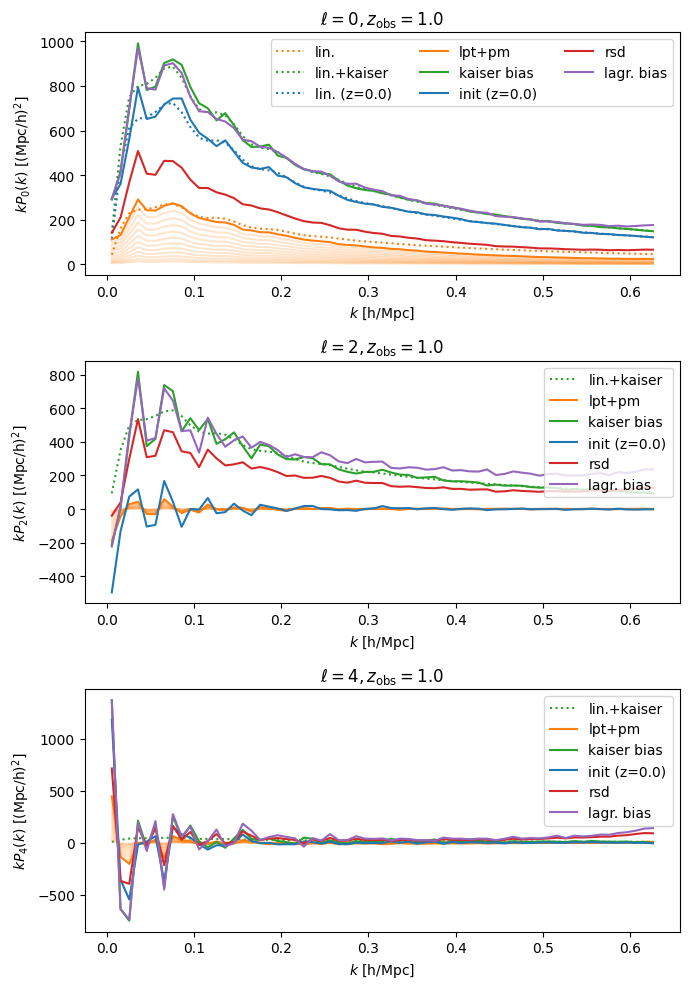

In [7]:
# pk_pm = pk_fn(compensate_cic(pm_mesh[0]))
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_obs, 'C1:', label=f"lin.")
    plot_fn(pk_kaiser_lin, 'C2:', label=f"lin.+kaiser")
    if multipole==0:
        plot_fn(pk_lin_init, 'C0:', label=f"lin. (z={1/1-1:.1f})")

    # plot_fn(pk_kaiser_init, 'C2--', label=f"init+kaiser")
    plot_fn(pk_pm[-1], 'C1', label=f"lpt+pm")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C1', alpha=0.2)
    plot_fn(pk_kaiser_bias, 'C2', label=f"kaiser bias ")
    plot_fn(pk_init, 'C0', label=f"init (z={1/1-1:.1f})")
    plot_fn(pk_rsd, 'C3', label=f"rsd")
    plot_fn(pk_bias, 'C4', label=f"lagr. bias") # TODO: noter +lpt+pm

    if multipole==0: plt.legend(ncols=3, loc='upper right')
    else: plt.legend(loc='upper right')
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_rsd{rsd:b}_smooth{smooth:b}.svg")
plt.show();

## Bias effects

In [30]:
b_vals = [-3, 3]
b_names = ['b2','bs','bnl']
b_namlabvals = [['b2=bs=bnl', '$b_2=b_s=b_{\\text{nl}}$', 0]]
for b_nam in b_names:
    for b_val in b_vals:
        b_lab, b_mean, b_std = config['prior_config'][b_nam]
        b_lab = '$'+b_lab+'$'
        b_val = (b_val - b_mean) / b_std
        b_namlabvals.append([b_nam+'_', b_lab, b_val])

pk_biases = []
for b_nam, _, b_val in b_namlabvals:
    cond_params = dict(fiduc_params)
    cond_params[b_nam] = b_val
    params = get_simulator(condition(model, cond_params))(rng_seed=0)
    pk_biases.append(pk_fn(compensate_cic(params['bias_mesh'])))
pk_biases = np.array(pk_biases)

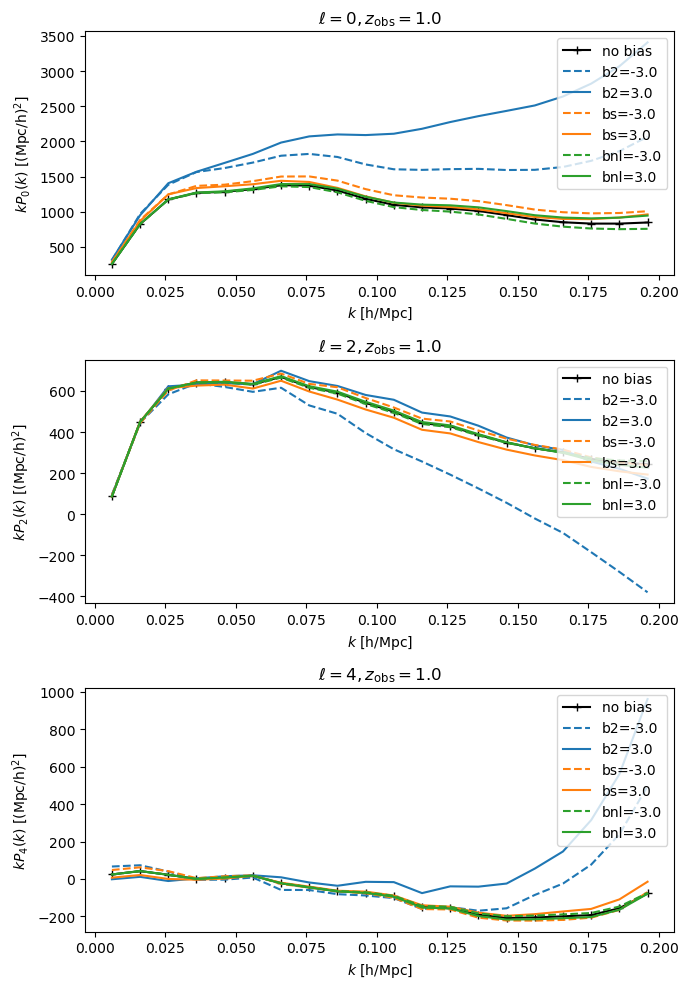

In [31]:
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    colors = ['k+-','C0','C1','C2']
    i_color = 0
    format = colors[i_color]
    for pk, (b_nam, b_lab, b_val), in zip(pk_biases, b_namlabvals):
        if b_val==0:
            label = "no bias"
        else:
            _, b_mean, b_std = config['prior_config'][b_nam[:-1]]
            label = b_nam[:-1]+f"={b_val*b_std+b_mean:.1f}"
            if b_val<0:
                i_color+=1
                format = colors[i_color]+'--'
            else:
                format = colors[i_color]
        plot_fn(pk, format, label=label)

    plt.legend(loc='upper right'), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_biases_rsd{rsd:b}_smooth{smooth:b}.svg")
plt.show();

## Validation 

In [32]:
# %pip install git+https://github.com/sfschen/ZeNBu -q
import numpy as np
from matplotlib import pyplot as plt

def get_pt(kv, klin, pklin, f=None):
    """
    Return Zeldovich prediction.

    Parameters
    ----------
    kv : array
        Output k.

    klin : array
        Input linear k.

    pklin : array
        Output P(k).

    f : float
        Growth rate.
    """
    from ZeNBu.zenbu import Zenbu
    from ZeNBu.zenbu_rsd import Zenbu_RSD
    cutoff = np.pi * 512 / 1000.
    if f is None:  # real space
        zobj = Zenbu(klin, pklin, jn=15, N=3000, cutoff=cutoff)
        zobj.make_ptable(kvec=kv)
        tmp = zobj.pktable.T[1:]  # first is k, drop it
        pktable = np.zeros((14,) + tmp.shape[1:], dtype='f8')
        pktable[:10, ...] = tmp[:10, ...]
        pktable[10:, ...] = -kv[np.newaxis, :]**2 * tmp[[0, 1, 3, 6], ...]  # nabla
        pktable = pktable[:, None, :]
    else:
        lpt = Zenbu_RSD(klin, pklin, jn=15, N=2500, cutoff=cutoff)
        lpt.make_pltable(f, kv=kv, nmax=8, ngauss=3)

        p0table = lpt.p0ktable
        p2table = lpt.p2ktable
        p4table = lpt.p4ktable

        pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
        pktable[:, 0, :] = p0table
        pktable[:, 1, :] = p2table
        pktable[:, 2, :] = p4table
        pktable = pktable.T

    return pktable


def get_pk(pktable, b1=1., b2=0., bs=0., bk2=0.):

    """Return galaxy power spectrum prediction."""
    pktable = pktable[:14]
    bias_monomials = np.array([1,
                                2*b1, b1**2,
                                b2, b1*b2, 0.25*b2**2,
                                2*bs, 2*b1*bs, b2*bs, bs**2,
                                2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs])

    # sum for each multipole and combine into pk
    return np.sum(bias_monomials[:, None, None] * pktable, axis=0)

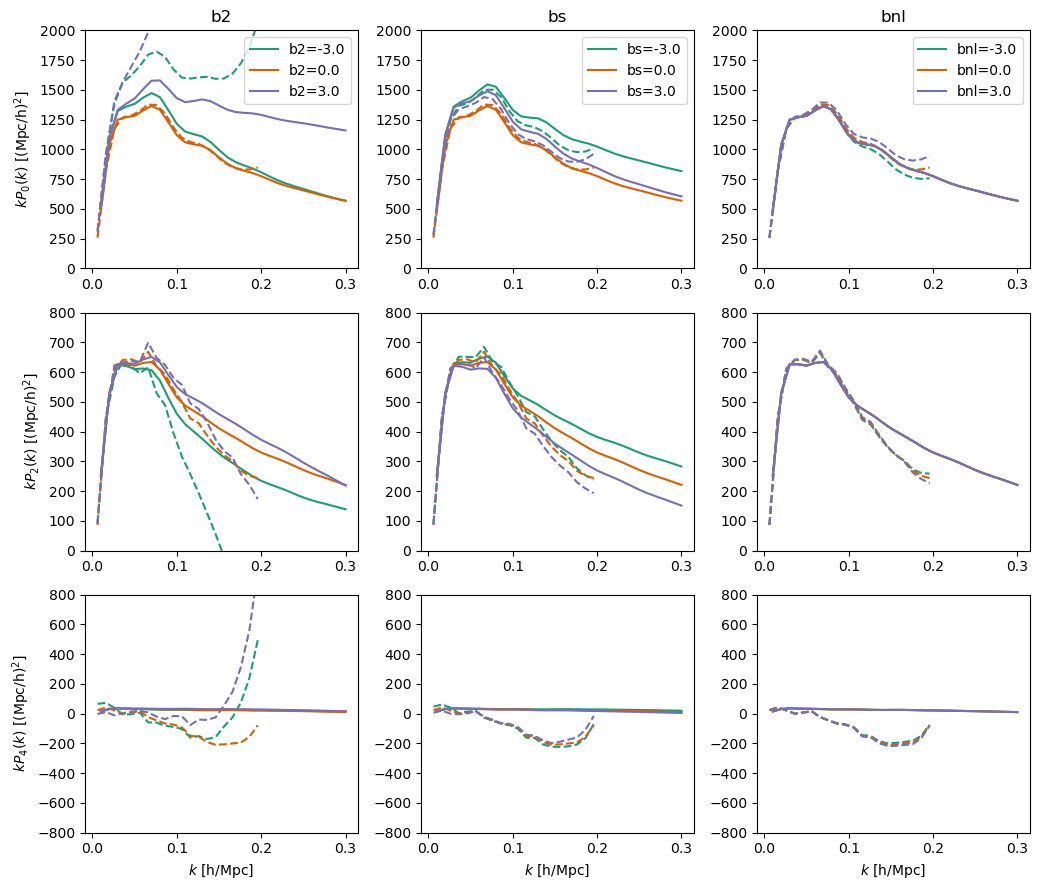

In [33]:
# kv = np.linspace(0.01, pk_biases[0,0,-1], 30)
pk_biases = pk_biases[:,:,:30]
kv = np.linspace(0.01, 0.3, 30)
klin = np.logspace(-3., 2, 1000)

# from cosmoprimo.fiducial import DESI
# cosmo = DESI()
# z = 1.
# f = cosmo.growth_rate(z)
# pklin = cosmo.get_fourier().pk_interpolator()(k=klin, z=z)
from jaxpm.growth import growth_factor, growth_rate
from montecosmo.bricks import linear_pk_interp
from jaxpm.painting import cic_compensation, compensate_cic

f = growth_rate(fiduc_cosmo, jnp.atleast_1d(config['a_obs']))
pklin = linear_pk_interp(fiduc_cosmo, config['a_obs'], n_interp=256)(klin)
k_nyquist = jnp.pi * jnp.min(config['mesh_size'] / config['box_size'])
if smooth:
    pklin = pklin * (jnp.exp(-.5 * klin**2 / k_nyquist**2))**2
# pklin = pklin / cic_compensation(klin / (config['mesh_size'] / config['box_size'])[0])**2

plt.figure(figsize=(lambda h:(3*h*7/6,(3 if rsd else 4/3)*h))(3))
if rsd:  # if RSD, k^2 not modelled?
    ells = (0, 2, 4)
    pktable = get_pt(kv, klin, pklin, f)
else:
    ells = (0,)
    pktable = get_pt(kv, klin, pklin, f=None)

biases = [('b2', np.linspace(-3., 3., 3)), ('bs', np.linspace(-3., 3., 3)), ('bnl', np.linspace(-3., 3., 3))]
for i_param, (param, values) in enumerate(biases):
    cmap = plt.get_cmap('Dark2')
    for i_value, value in enumerate(values):
        if param=='bnl': params = {'bk2':-value} # NOTE: bk2 = -bnl
        else: params = {param:value}
        poles = get_pk(pktable, **params)
        # color = cmap((i_value+.5) / (len(values)-.5))
        color = cmap(i_value / 7)
        # color = ['C0','C1','C4'][i_value]
        for ill, ell in enumerate(ells):
            plt.subplot(len(ells),len(biases),i_param+1+ill*len(biases))
            plt.plot(kv, kv * poles[ill], color=color, label=f"{param}={value:.1f}")
            # plt.loglog(kv, poles[ill], color=color, label=f"{param}={value:.1f}")
            # plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[ill+1], *args, **kwargs)
            plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[ill+1], *args, **kwargs)
            if value<0:
                plot_fn(pk_biases[1+2*i_param], '--', color=color)
            elif value>0:
                plot_fn(pk_biases[2+2*i_param], '--', color=color)
            else:
                plot_fn(pk_biases[0], '--', color=color)
            if ill==0: plt.title(f"{param}"), plt.legend(loc='upper right'), plt.ylim(0, 2000)
            if ill==1: plt.ylim(0, 800)
            if ill==2: plt.ylim(-800, 800)
            if i_param==0: plt.ylabel(f"$k P_{ell}(k)$ [(Mpc/h)$^2$]")
            # if i_param==0: plt.ylabel(f"$P_{ell}(k)$ [(Mpc/h)$^3$]")
            if ill==len(ells)-1: plt.xlabel("$k$ [h/Mpc]")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_biasvalid_rsd{rsd:b}_smooth{smooth:b}_{int(config['box_size'][0])}.svg")
plt.show()

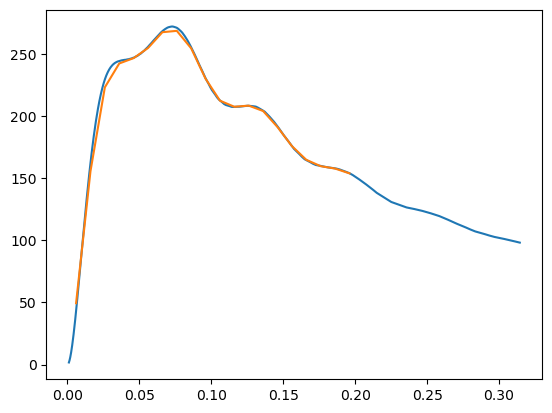

In [34]:
from jaxpm.growth import growth_factor, growth_rate

kmax = 500
plt.plot(klin[:kmax], klin[:kmax]*pklin[:kmax])
plt.plot(pk_init[0], pk_init[0]*pk_init[1]*growth_factor(fiduc_cosmo, jnp.array([config['a_obs']]))**2 )

## Cubes

In [7]:
from matplotlib.colors import Normalize
def plot_cube_vox(mesh, mesh_size, box_size, cmap='viridis', vmin=None, vmax=None, **config):
    xx, yy, zz = np.indices(mesh_size)
    cube = (xx==mesh_size[0]-1) | (yy==0) | (zz==mesh_size[2]-1)
    cube = cube | (xx==0) | (yy==mesh_size[1]-1)
    xx, yy, zz = np.indices(mesh_size+1) * (box_size/mesh_size)[:,None,None,None]
    cmap = plt.get_cmap(cmap)
    ax3d = plt.gca()

    norm = Normalize(vmin, vmax)
    if vmin is None and vmax is None:
        norm.autoscale(mesh)
    m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    faces = ax3d.voxels(xx, yy, zz, cube, facecolors=cmap(norm(mesh)), shade=False)
    ax3d.set_xlabel("$x$ [Mpc/h]"), ax3d.set_ylabel("$y$ [Mpc/h]"), ax3d.set_zlabel("$z$ [Mpc/h]")
    return m

def plot_cube_scat(mesh, mesh_size, box_size, cmap='viridis', alpha=None, vmin=None, vmax=None, **config):
    xx, yy, zz = np.indices(mesh_size)
    cube = (xx==mesh_size[0]-1) | (yy==0) | (zz==mesh_size[2]-1)
    # cube = cube | (xx==0) | (yy==mesh_size[1]-1)
    # cube = (xx>=mesh_size[0]-1-5) | (yy<=0+5) | (zz>=mesh_size[2]-1-5)
    # cube = cube | (xx<=0+5) | (yy>=mesh_size[1]-1-5)
    # cube = cube & (mesh > vmin)
    xx, yy, zz = (np.indices(mesh_size) * (box_size/mesh_size)[:,None,None,None])[:,cube]
    ax3d = plt.gca()

    p3d = ax3d.scatter(xx, yy, zz, marker =".", c=mesh[cube], alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    ax3d.set_xlabel("$x$ [Mpc/h]"), ax3d.set_ylabel("$y$ [Mpc/h]"), ax3d.set_zlabel("$z$ [Mpc/h]")
    # ax3d.set_xlabel("$x\; [\\text{Mpc}/h]$"), ax3d.set_ylabel("$y\; [\\text{Mpc}/h]$"), ax3d.set_zlabel("$z\; [\\text{Mpc}/h]$")
    # ax3d.set_xlabel("$x\; [\\textrm{Mpc}/h]$"), ax3d.set_ylabel("$y\; [\\textrm{Mpc}/h]$"), ax3d.set_zlabel("$z\; [\\textrm{Mpc}/h]$")
    return p3d, cube

In [10]:
%matplotlib inline
from matplotlib import animation
from jaxpm.growth import growth_factor, growth_rate
init_zlpt = 1+growth_factor(fiduc_cosmo, jnp.atleast_1d(config['a_lpt'])) * fiduc_params['init_mesh']
obs_mesh_comp = fiduc_params['obs_mesh'] / (config['galaxy_density'] * config['box_size'].prod() / config['mesh_size'].prod())

meshes = jnp.array([init_zlpt, *pm_mesh, fiduc_params['bias_prersd_mesh'], fiduc_params['bias_mesh'], obs_mesh_comp])#[:-1]
# snapshots = np.linspace(config['a_lpt'], config['a_obs'], config['trace_meshes'])
snapshots = np.linspace(config['a_lpt'], config['a_obs'], len(pm_mesh))
titles_pm = ['lpt+pm'+f", z={1/a-1:.1f}" for a in snapshots]
titles = [f"init, z={1/config['a_lpt']-1}", 
          *titles_pm, 
          f"bias, z={1/config['a_obs']-1}", 
          f"rsd, z={1/config['a_obs']-1}", 
          f"obs, z={1/config['a_obs']-1}",]#[:-1]
# i_reps = np.cumsum([30, *([15]+(len(pm_mesh)-2)*[1]+[15]), 30, 30, 30], dtype=int)
# i_reps = np.cumsum([10, *([10]+(len(pm_mesh)-2)*[1]+[10]), 10, 10, 30], dtype=int)
# i_reps = np.cumsum([20, *([20]+(len(pm_mesh)-2)*[1]+[20]), 20, 20, 50], dtype=int)
i_reps = np.cumsum([20, *([10]+(len(pm_mesh)-2)*[1]+[20]), 20, 20, 50], dtype=int)
# i_reps = 5+2*np.arange(len(i_reps))#[:-1]
assert len(i_reps)==len(titles)==len(meshes)
vmin, vmax = get_vlim(5*1e-3, 1)(meshes)
# vmin, vmax = get_vlim(3*1e-3, 1)(meshes)
# vmin, vmax = None, None

dark_theme = True
plot_fn = plot_cube_scat
theme = theme_switch(dark_theme)
nrows, ncols = 1, 1

plt.figure(figsize=(lambda h:(ncols*h*7/6,nrows*h))(7))
ax3d = plt.subplot(nrows, ncols,1, projection='3d')
p3d, cube = plot_fn(meshes[0], cmap='viridis', min=vmin, vmax=vmax, **config)
# p3d, cube = plot_fn(meshes[-2], cmap='viridis', vmin=0.5*vmax, vmax=2*vmax, alpha=0.2, **config)
title = plt.title(titles[0], fontsize=16)

# Remove some of the grid
ax3d.xaxis.set_pane_color((1,1,1,0))
ax3d.yaxis.set_pane_color((1,1,1,0))
ax3d.zaxis.set_pane_color((1,1,1,0))
# ax3d.xaxis.pane.set_edgecolor((1,1,1,0))
# ax3d.xaxis.pane.fill = False
# plt.axis("off")
ax3d.grid(False)

# plt.colorbar(p3d, location='right').set_label("$1+\delta$")
plt.tight_layout()

def update(i):
    i_toplot_old = -1
    # ax3d.view_init(elev=30, azim=-i-91) # -60
    ax3d.view_init(elev=30, azim=-60) # -60
    if i < i_reps[-1]:
        i_toplot = np.digitize(i, i_reps)
        if i_toplot != i_toplot_old:
            # xx, yy, zz = np.indices(config['mesh_size'])
            # cube = meshes[i_toplot] > 0.5*(vmax - vmin)
            # xx, yy, zz = (np.indices(config['mesh_size']) * (config['box_size']/config['mesh_size'])[:,None,None,None])[:,cube]
            # p3d._offsets3d = xx, yy, zz

            p3d.set_array(meshes[i_toplot][cube])
            title.set_text(titles[i_toplot])
        i_toplot_old = i_toplot
    elif i < i_reps[-1] + 90:
        ax3d.view_init(elev=30, azim=-(i-i_reps[-1])-60) # -60
    return plt.gcf(), p3d, title


# plt.savefig('todel.png', dpi=100)
# plt.savefig('todel2.png', dpi=200)
save_name = f"scat_ms{config['mesh_size'][0]:d}_dkth{dark_theme:b}_fila"
# # mlflow.log_figure(plt.gcf(), save_name+".svg")
anim = animation.FuncAnimation(plt.gcf(), update, frames=i_reps[-1], interval=100, blit=True)
plt.close(), 
display(anim)
anim.save(save_name+".mp4", dpi=200)
anim.save(save_name+".gif", dpi=200)
# mlflow.log_artifact(save_name+".mp4")

/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


<Figure size 640x480 with 0 Axes>